In [1]:
'''
三分类语义分割
代码分为几段，段之间以空cell隔开

相较上个版本的修改有：
1.削弱了数据增强的变动幅度，删去翻转的情况
2.将点云转体素时的标签分配方法改为投票法
3.重新选择损失函数，CE + Dice + Tversky + Focal
4.用插值消除阶梯状边缘
5.用形态学调整去洞、收紧轮廓线宽度
6.轮廓线重建

测试过但未加入的要素有：
1.边缘损失，没效果
2.更大的体素网格，还是因为受内存限制而无法实现
2.CRF，我们没法要求客户费劲安装环境，不方便等于找骂
3.高斯模糊等卷积滤波器，会起到负面效果——让轮廓线部分消失

在原理上，边缘检测可以使用几乎相同的模型，这意味着：
1.语义分割中也可以加入边缘标签
2.只保留边缘标签时数据更稀疏，或许适用更高分辨率的体素网格


'\n三分类语义分割\n代码分为几段，段之间以空cell隔开\n\n修改了：\n1.削弱了数据增强的变动幅度，删去翻转的情况\n2.将点云转体素时的标签分配方法改为投票法\n3.重新选择损失函数，取Focal、Tversky和自己编写的Boundary\n4.在可视化部分增加了用插值和CRF增加分辨率的方法\n\n在原理上，边缘检测可以使用几乎相同的模型，这意味着：\n1.语义分割中也可以加入边缘标签\n2.只保留边缘标签时数据更稀疏，或许适用更高分辨率的体素网格\n'

In [1]:
'''
统一设置地址
'''

import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)

# 修改当前工作目录，以后输出文件只需要写文件名
new_dir = "D:/李娅宁/肩台外侧点-0715/"
os.chdir(new_dir)
print("修改后的工作目录：", os.getcwd())


当前工作目录： C:\Users\HP
修改后的工作目录： D:\李娅宁\肩台外侧点-0715


In [3]:
'''
训练UNET
'''

'\n训练UNET\n'

In [4]:
'''
加载并处理数据
非常慢，建议每次加载并处理后先行保存
'''

import numpy as np
from scipy.ndimage import rotate
from scipy.stats import mode
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

# 创建带标签的体素网格
def create_labeled_voxel_grid(data, labels, grid_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size), dtype=int)  # Initialize with 0 to indicate empty space

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    voxel_label_dict = {}

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        voxel_key = tuple(voxel)
        
        if voxel_key not in voxel_label_dict:
            voxel_label_dict[voxel_key] = []
        voxel_label_dict[voxel_key].append(labels[i])

    for voxel_key, label_list in voxel_label_dict.items():
        # 计算众数
        mode_result = mode(label_list)
        
        # 获取众数标签
        most_common_label = mode_result.mode  # mode_result.mode 是一个标量
        
        grid[voxel_key] = 1
        label_grid[voxel_key] = most_common_label

    return grid, label_grid

# 数据增强，对体素网格进行随机三轴小幅旋转
def augment_voxel_grid(voxel_grid):
    # 随机旋转角度（-10到10度）
    angles = np.random.uniform(-10, 10, size=3)
    
    # 对每个轴进行旋转
    voxel_grid = rotate(voxel_grid, angle=angles[0], axes=(1, 0), reshape=False, order=1, mode='nearest')
    voxel_grid = rotate(voxel_grid, angle=angles[1], axes=(2, 0), reshape=False, order=1, mode='nearest')
    voxel_grid = rotate(voxel_grid, angle=angles[2], axes=(2, 1), reshape=False, order=1, mode='nearest')
    
    return voxel_grid


# 从文件夹中读取数据并加工成体素网格
def load_data_from_directory(data_dir, grid_size=16):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_labeled_voxel_grid(data, labels, grid_size)
            if voxel_grid is not None and label_grid is not None:
                # 关闭数据增强
                # voxel_grid = augment_voxel_grid(voxel_grid)
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.expand_dims(np.array(y_data), axis=-1)
    return x_data, y_data


# 加载数据
data_dir = '重新处理后的数据_手工筛选'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)

# 确保标签是0, 1, 2
y_data = y_data.astype(np.int32)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)


In [5]:
# 保存加载好的数据备用
def save_processed_data(x_data, y_data, folder_path, file_prefix):

    # 确保文件夹存在
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # 保存数据到指定文件夹
    np.save(os.path.join(folder_path, f'{file_prefix}_x_data.npy'), x_data)
    np.save(os.path.join(folder_path, f'{file_prefix}_y_data.npy'), y_data)

data_folder_path = 'July31语义分割模型'
data_file_prefix = 'July31语义分割数据'
save_processed_data(x_data, y_data, data_folder_path, data_file_prefix)

In [2]:
'''
重新加载已保存的处理好的数据
如果已有数据则跳过此cell
'''

import numpy as np
from scipy.ndimage import rotate
from scipy.stats import mode
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_processed_data(folder_path, file_prefix):
    x_data = np.load(os.path.join(folder_path, f'{file_prefix}_x_data.npy'))
    y_data = np.load(os.path.join(folder_path, f'{file_prefix}_y_data.npy'))
    return x_data, y_data

# 加载保存的数据
data_folder_path = 'July31语义分割模型'
data_file_prefix = 'July31语义分割数据'
x_data, y_data = load_processed_data(data_folder_path, data_file_prefix)


# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)



In [3]:
# 绘制训练过程中的损失和精确度
def plot_training_history(history):
    """
    绘制训练过程中的损失和精确度。
    """
    # 绘制损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 绘制精确度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [4]:
# 定义UNET模型
def unet_3d(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv1)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool1)
    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool2)
    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv3)
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool3)
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv4)

    # Decoder
    up5 = tf.keras.layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv3], axis=-1)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat5)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv5)

    up6 = tf.keras.layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2], axis=-1)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat6)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv6)

    up7 = tf.keras.layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1], axis=-1)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat7)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv7)

    # 修改输出层，适应3个类别
    outputs = tf.keras.layers.Conv3D(3, 1, activation='softmax')(conv7)  # 3 channels for three-class classification

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [2]:
'''
定义各种损失函数
'''

import tensorflow.keras.backend as K
import numpy as np
import tensorflow as tf
from scipy.spatial.distance import cdist


# 交叉熵
def cross_entropy_loss(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))

# Dice
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3, 4])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3, 4]) + tf.reduce_sum(y_pred, axis=[1, 2, 3, 4])
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return tf.reduce_mean(1 - dice)

# Focal
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # 确保 y_true 和 y_pred 都是 float32 类型
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        # 计算交叉熵
        cross_entropy = -y_true * tf.math.log(y_pred)
        # 计算 focal 权重
        focal_weight = alpha * tf.math.pow(1 - y_pred, gamma)
        # 计算 focal loss
        loss = focal_weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return focal_loss_fixed


# Tversky
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3, 4])
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3, 4])
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3, 4])
    
    tversky = (intersection + smooth) / (intersection + alpha * false_neg + beta * false_pos + smooth)
    
    return tf.reduce_mean(1 - tversky)


# 组合损失函数
@tf.function
def combined_loss(y_true, y_pred):
    ce_loss = cross_entropy_loss(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    tversky = tversky_loss(y_true, y_pred)
    focal = focal_loss(gamma=2.0, alpha=0.25)(y_true, y_pred)
    
    return ce_loss + dice + tversky + focal



'''
'''
# 使用 TensorFlow 实现 Sobel 边缘检测
'''
def sobel_filter_3d():
    # 创建 Sobel 滤波器，注意这里设置 input_depth 为 1
    filters = {
        'x': tf.constant([[[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]],
                           [[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]],
                           [[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]]], dtype=tf.float32),
        'y': tf.constant([[[[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]],
                           [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]],
                           [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]]]], dtype=tf.float32),
        'z': tf.constant([[[[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]],
                           [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]],
                           [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]]]], dtype=tf.float32)
    }
    
    # 过滤器的形状应该为 (depth, height, width, in_channels, out_channels)
    filters['x'] = tf.reshape(filters['x'], [3, 3, 3, 1, 1])
    filters['y'] = tf.reshape(filters['y'], [3, 3, 3, 1, 1])
    filters['z'] = tf.reshape(filters['z'], [3, 3, 3, 1, 1])

    return filters

def apply_sobel_filters(volume, filters):
    volume = tf.expand_dims(volume, axis=-1)  # Ensure volume has channel dimension
    
    conv_x = tf.nn.conv3d(volume, filters['x'], strides=[1, 1, 1, 1, 1], padding='SAME')
    conv_y = tf.nn.conv3d(volume, filters['y'], strides=[1, 1, 1, 1, 1], padding='SAME')
    conv_z = tf.nn.conv3d(volume, filters['z'], strides=[1, 1, 1, 1, 1], padding='SAME')

    edges = tf.sqrt(tf.square(conv_x) + tf.square(conv_y) + tf.square(conv_z))
    return edges

def compute_sobel_edges_3d(volume):
    filters = sobel_filter_3d()
    edges = apply_sobel_filters(volume, filters)
    return edges



'''
# Boundary Loss
'''
# 欧几里得边界损失函数
@tf.function
def euclidean_distance_loss(true_edges, pred_edges):
    distance = tf.sqrt(tf.reduce_sum(tf.square(true_edges - pred_edges), axis=[1, 2, 3, 4]))
    return tf.reduce_mean(distance)

# 二进制交集边界损失函数
@tf.function
def binary_intersection_loss(true_edges, pred_edges):
    intersection = tf.reduce_sum(tf.cast(true_edges > 0, tf.float32) * tf.cast(pred_edges > 0, tf.float32), axis=[1, 2, 3, 4])
    return tf.reduce_mean(1 - intersection)


# 组合损失函数
@tf.function
def combined_loss(y_true, y_pred):
    
    # 确保 y_true 和 y_pred 是浮点型
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # 使用掩码来只关注标签1和标签2
    true_mask = tf.logical_or(tf.equal(y_true, 1), tf.equal(y_true, 2))
    pred_mask = tf.logical_or(tf.equal(y_pred, 1), tf.equal(y_pred, 2))
    
    # 将掩码应用于标签网格和预测网格
    y_true_masked = tf.where(true_mask, y_true, tf.zeros_like(y_true))
    y_pred_masked = tf.where(pred_mask, y_pred, tf.zeros_like(y_pred))
    
    # 计算真实边界和预测边界
    true_edges = compute_sobel_edges_3d(y_true_masked)
    pred_edges = compute_sobel_edges_3d(y_pred_masked)
    
    # 计算边界损失
    boundary_loss_euclidean = euclidean_distance_loss(true_edges, pred_edges)
    boundary_loss_intersection = binary_intersection_loss(true_edges, pred_edges)
    
    # 定义损失函数
    focal_loss_func = focal_loss(gamma=2.0, alpha=0.25)  # Create focal loss function
    focal = focal_loss_func(y_true, y_pred)  # Compute focal loss
    tversky = tversky_loss(y_true, y_pred)
    
    # 为每个损失函数赋权
    weight_focal = 1.5
    weight_tversky = 1.0
    weight_euclidean = 0.002
    weight_intersection = 1.0
    
    # 求和
    total_loss = (weight_focal * focal + 
                  weight_tversky * tversky + 
                  weight_euclidean * boundary_loss_euclidean +
                  weight_intersection * boundary_loss_intersection)
    
    return total_loss
'''

'\n# 欧几里得边界损失函数\n@tf.function\ndef euclidean_distance_loss(true_edges, pred_edges):\n    distance = tf.sqrt(tf.reduce_sum(tf.square(true_edges - pred_edges), axis=[1, 2, 3, 4]))\n    return tf.reduce_mean(distance)\n\n# 二进制交集边界损失函数\n@tf.function\ndef binary_intersection_loss(true_edges, pred_edges):\n    intersection = tf.reduce_sum(tf.cast(true_edges > 0, tf.float32) * tf.cast(pred_edges > 0, tf.float32), axis=[1, 2, 3, 4])\n    return tf.reduce_mean(1 - intersection)\n\n\n# 组合损失函数\n@tf.function\ndef combined_loss(y_true, y_pred):\n    \n    # 确保 y_true 和 y_pred 是浮点型\n    y_true = tf.cast(y_true, tf.float32)\n    y_pred = tf.cast(y_pred, tf.float32)\n    \n    # 使用掩码来只关注标签1和标签2\n    true_mask = tf.logical_or(tf.equal(y_true, 1), tf.equal(y_true, 2))\n    pred_mask = tf.logical_or(tf.equal(y_pred, 1), tf.equal(y_pred, 2))\n    \n    # 将掩码应用于标签网格和预测网格\n    y_true_masked = tf.where(true_mask, y_true, tf.zeros_like(y_true))\n    y_pred_masked = tf.where(pred_mask, y_pred, tf.zeros_like(y_

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.7240 - loss: 2.5849 - val_accuracy: 0.7568 - val_loss: 2.4244 - learning_rate: 3.0000e-05
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7945 - loss: 2.3500 - val_accuracy: 0.9037 - val_loss: 2.1876 - learning_rate: 3.0000e-05
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9117 - loss: 2.1746 - val_accuracy: 0.9307 - val_loss: 2.1440 - learning_rate: 3.0000e-05
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9345 - loss: 2.1388 - val_accuracy: 0.9346 - val_loss: 2.1183 - learning_rate: 3.0000e-05
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9446 - loss: 2.1134 - val_accuracy: 0.9569 - val_loss: 2.0980 - learning_rate: 3.0000e-05
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9546 - loss: 2.0946 - val_accuracy: 0.9570 - val_loss: 2.0834 - learning_rate: 2.7145e-05
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9603 

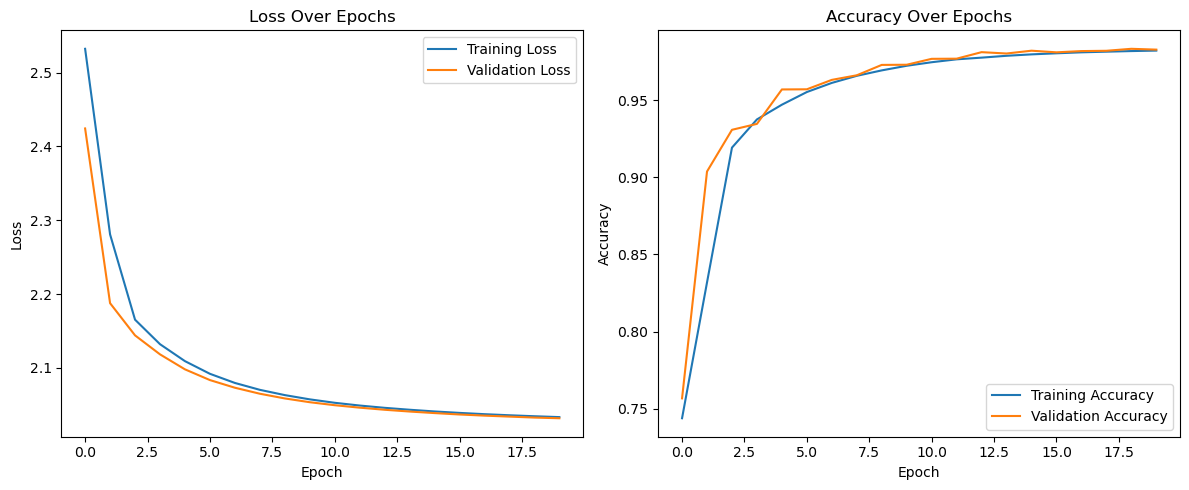

Model saved to July31语义分割模型/UNET.h5


In [6]:
# 定义模型
input_shape = (16, 16, 16, 1)
model = unet_3d(input_shape)

# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

# 定义学习率调度回调和早停回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003), 
              loss=combined_loss,
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    x_train, y_train, 
    validation_split=0.1,
    epochs=20, 
    batch_size=10,
    callbacks=[lr_scheduler, early_stopping]
)

# 评估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 显示炼丹过程
plot_training_history(history)

# 保存模型
model_save_path = 'July31语义分割模型/UNET.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


In [ ]:
'''
预测及可视化——稳定版1——不加任何平滑处理
基于拓扑图绘制1-2区域分界线
'''

In [3]:
# 加载模型，如果已经有模型可以不运行这个cell
model_load_path = 'July31语义分割模型/UNET.h5'

# 自定义损失函数字典
custom_objects = {
    'cross_entropy_loss': cross_entropy_loss,
    'dice_loss': dice_loss,
    'focal_loss': focal_loss,
    'tversky_loss': tversky_loss,
    'combined_loss': combined_loss
}

try:
    model = tf.keras.models.load_model(model_load_path, custom_objects=custom_objects)
    print("模型加载成功！")
except Exception as e:
    print("模型加载失败:", e)

模型加载成功！


In [4]:
# 开启交互旋转
%matplotlib notebook


In [26]:
'''
读取点云并对预测每点的类别标签
'''

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations

def load_obj_file(file_path):
    vertices = []
    faces = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):
                vertices.append(list(map(float, line.strip().split()[1:])))
            elif line.startswith('f '):
                faces.append([int(idx.split('/')[0]) - 1 for idx in line.strip().split()[1:]])
    return np.array(vertices), np.array(faces)

def center_vertices(vertices):
    centroid = np.mean(vertices, axis=0)
    return vertices - centroid

def create_voxel_grid(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.int32)
    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]] += 1
    
    return voxel_grid, min_coords, voxel_dim

def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    
    labels = np.argmax(predictions, axis=-1)  # Get the class with the highest probability
    labels = labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])
    
    return labels

def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels


In [12]:
'''
给点云画拓扑图
'''

import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors

def build_topology_graph(vertices, k=10):
    # 计算k近邻图
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(vertices)
    distances, indices = nbrs.kneighbors(vertices)
    
    G = nx.Graph()
    for i, neighbors in enumerate(indices):
        for j in neighbors:
            if i != j:
                G.add_edge(i, j)
                
    return G

def largest_connected_component(G, nodes):
    subgraph = G.subgraph(nodes)
    largest_cc = max(nx.connected_components(subgraph), key=len)
    return subgraph.subgraph(largest_cc)

def get_max_connected_subgraphs(G, labels, target_labels):
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, l in enumerate(labels) if l == label]
        if nodes:
            largest_cc = largest_connected_component(G, nodes)
            subgraphs[label] = largest_cc
    return subgraphs



In [13]:
'''
找1-2的边界线
'''

def find_boundary_edges(G, subgraph1, subgraph2):
    boundary_edges = []
    for edge in G.edges():
        if (edge[0] in subgraph1 and edge[1] in subgraph2) or (edge[0] in subgraph2 and edge[1] in subgraph1):
            boundary_edges.append(edge)
    return boundary_edges

def plot_surface_with_boundary_lines(vertices, faces, labels, boundary_edges, view_angles=(30, 30), angles=(0, 0, 0)):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.art3d import Line3DCollection

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T
    
    # 绘制不同标签区域的点云
    colors = ['lightgreen', 'cornflowerblue', 'honeydew']
    for i in range(3):
        part_faces = [face for face in faces if sum(labels[vertex] == i for vertex in face) > 1]
        if len(part_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part_faces, color=colors[i], alpha=0.6)
    
    # 绘制边界线
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red', lw=1)
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()


In [14]:
'''
设置视角
'''

def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


<IPython.core.display.Javascript object>


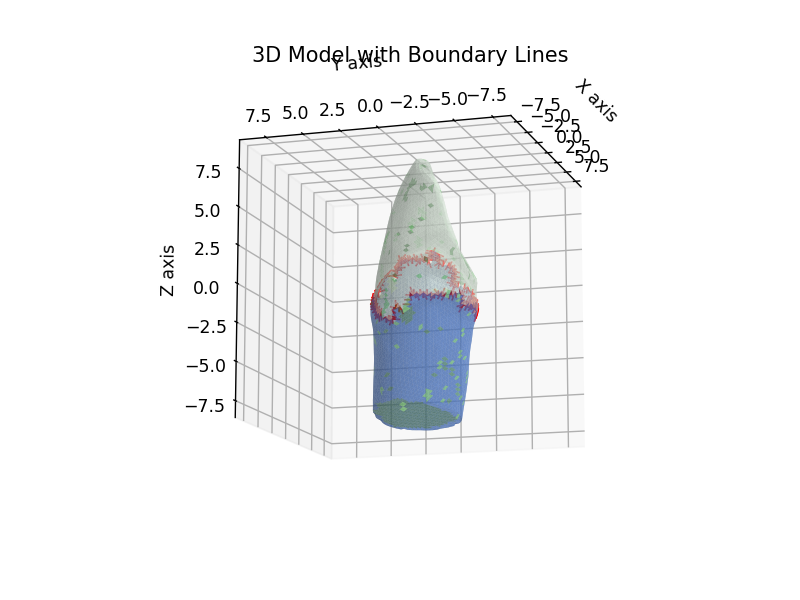

In [15]:
'''
出图
'''

# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/15/15_1.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 构建拓扑图
G = build_topology_graph(centered_vertices)

# 找到最大连通子图
target_labels = [1, 2]
subgraphs = get_max_connected_subgraphs(G, predicted_point_labels, target_labels)

# 找到边界线
boundary_edges = find_boundary_edges(G, subgraphs[1], subgraphs[2])

# 绘制点云及边界线
plot_surface_with_boundary_lines(centered_vertices, faces, predicted_point_labels, boundary_edges, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


In [ ]:
'''
数据可视化——稳定版2——用插值制造更大体素网格，以使分割线平滑，代价是可能降低面上像素分类的准确率
'''

In [ ]:
# 加载模型，如果已经有模型可以不运行这个cell
import tensorflow as tf

model_load_path = 'July31语义分割模型/UNET.h5'

# 自定义损失函数字典
custom_objects = {
    'cross_entropy_loss': cross_entropy_loss,
    'dice_loss': dice_loss,
    'focal_loss': focal_loss,
    'tversky_loss': tversky_loss,
    'combined_loss': combined_loss
}

try:
    model = tf.keras.models.load_model(model_load_path, custom_objects=custom_objects)
    print("模型加载成功！")
except Exception as e:
    print("模型加载失败:", e)

In [ ]:
# 开启交互旋转
%matplotlib notebook

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Shape of predicted_probabilities: (16, 16, 16, 3)
Unique values in predicted_probabilities: [0.0000000e+00 2.3888577e-38 2.4525705e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
Shape of upscaled_voxel_grid: (64, 64, 64)
Shape of upscaled_probabilities: (64, 64, 64, 3)
Unique values in upscaled_probabilities: [-0.37904257 -0.37270755 -0.37166154 ...  1.4023005   1.4231937
  1.4265525 ]
Shape of predicted_point_labels: (4556,)
Predicted_point_labels: [1. 0. 1. ... 2. 0. 2.]
Unique values in predicted_point_labels: [0. 1. 2.]


<IPython.core.display.Javascript object>


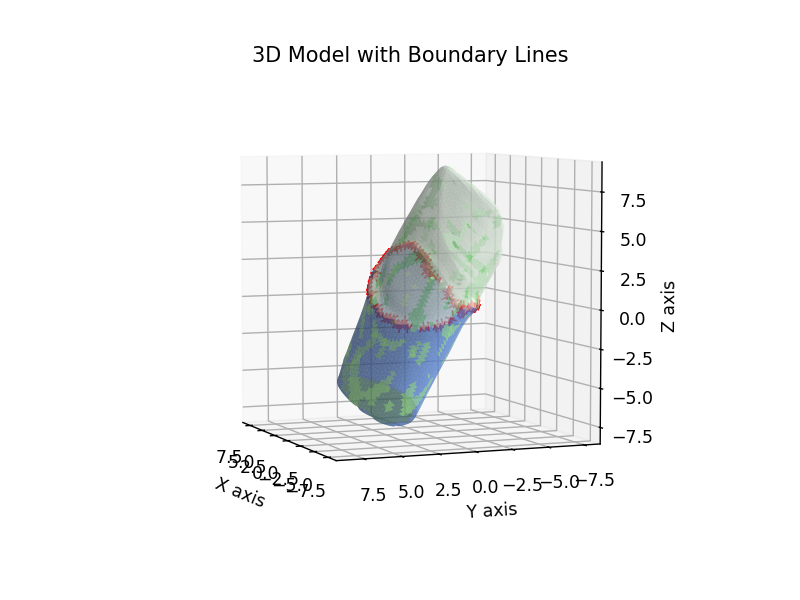

In [72]:
import numpy as np
import tensorflow as tf
from scipy.ndimage import zoom
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def load_obj_file(file_path):
    vertices = []
    faces = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):
                vertices.append(list(map(float, line.strip().split()[1:])))
            elif line.startswith('f '):
                faces.append([int(idx.split('/')[0]) - 1 for idx in line.strip().split()[1:]])
    return np.array(vertices), np.array(faces)

def center_vertices(vertices):
    centroid = np.mean(vertices, axis=0)
    return vertices - centroid

def create_voxel_grid(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.int32)
    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]] += 1
    
    return voxel_grid, min_coords, voxel_dim

def get_probabilities_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    
    # predictions should have shape (1, grid_size, grid_size, grid_size, num_classes)
    # Remove batch dimension
    probabilities = np.squeeze(predictions, axis=0)  # Shape: (grid_size, grid_size, grid_size, num_classes)
    
    return probabilities

def upscale_voxel_grid_and_probs(voxel_grid, probs, new_grid_size):
    old_size = voxel_grid.shape[0]
    scale_factor = new_grid_size / old_size

    # 使用最近邻插值来放大二进制体素网格
    new_voxel_grid = zoom(voxel_grid, zoom=scale_factor, order=0)  # 使用最近邻插值

    # 放大概率
    num_classes = probs.shape[-1]
    upscaled_probs = np.zeros((new_grid_size, new_grid_size, new_grid_size, num_classes), dtype=np.float32)
    
    for i in range(num_classes):
        prob_class = probs[..., i]
        prob_class_upscaled = zoom(prob_class, zoom=scale_factor, order=3)  # 使用三次插值
        upscaled_probs[..., i] = prob_class_upscaled

    return new_voxel_grid, upscaled_probs

def apply_labels_to_point_cloud(data, predicted_probabilities, min_coords, original_voxel_dim, original_grid_size, new_grid_size):
    labels = np.zeros(len(data))
    # 重新计算放大后的体素维度
    voxel_dim = (original_voxel_dim * original_grid_size) / new_grid_size
    
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, new_grid_size-1)
        labels[i] = np.argmax(predicted_probabilities[voxel[0], voxel[1], voxel[2]])
    return labels

def build_topology_graph(vertices, k=10):

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(vertices)
    distances, indices = nbrs.kneighbors(vertices)
    
    G = nx.Graph()
    for i, neighbors in enumerate(indices):
        for j in neighbors:
            if i != j:
                G.add_edge(i, j)
                
    return G

def largest_connected_component(G, nodes):
    subgraph = G.subgraph(nodes)
    largest_cc = max(nx.connected_components(subgraph), key=len)
    return subgraph.subgraph(largest_cc)

def get_max_connected_subgraphs(G, labels, target_labels):
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, l in enumerate(labels) if l == label]
        if nodes:
            largest_cc = largest_connected_component(G, nodes)
            subgraphs[label] = largest_cc
    return subgraphs

def find_boundary_edges(G, subgraph1, subgraph2):
    boundary_edges = []
    for edge in G.edges():
        if (edge[0] in subgraph1 and edge[1] in subgraph2) or (edge[0] in subgraph2 and edge[1] in subgraph1):
            boundary_edges.append(edge)
    return boundary_edges

def plot_surface_with_boundary_lines(vertices, faces, labels, boundary_edges, view_angles=(30, 30), angles=(0, 0, 0)):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.art3d import Line3DCollection

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T
    
    # 绘制不同标签区域的点云
    colors = ['lightgreen', 'cornflowerblue', 'honeydew']
    for i in range(3):
        part_faces = [face for face in faces if sum(labels[vertex] == i for vertex in face) > 1]
        if len(part_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part_faces, color=colors[i], alpha=0.6)
    
    # 绘制边界线
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red', lw=1)
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T


# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/15/15_1.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
original_grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, original_voxel_dim = create_voxel_grid(np.array(centered_vertices), original_grid_size)

# 使用训练好的模型进行预测
predicted_probabilities = get_probabilities_from_model(model, voxel_grid)
print("Shape of predicted_probabilities:", predicted_probabilities.shape)
print("Unique values in predicted_probabilities:", np.unique(predicted_probabilities))

# 等比扩大体素网格
new_grid_size = 64  # Example new grid size, adjust as needed
upscaled_voxel_grid, upscaled_probabilities = upscale_voxel_grid_and_probs(voxel_grid, predicted_probabilities, new_grid_size)
print("Shape of upscaled_voxel_grid:", upscaled_voxel_grid.shape)
print("Shape of upscaled_probabilities:", upscaled_probabilities.shape)
print("Unique values in upscaled_probabilities:", np.unique(upscaled_probabilities))

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(centered_vertices, upscaled_probabilities, min_coords, original_voxel_dim, original_grid_size, new_grid_size)
print("Shape of predicted_point_labels:", predicted_point_labels.shape)
print("Predicted_point_labels:", predicted_point_labels)
print("Unique values in predicted_point_labels:", np.unique(predicted_point_labels))


# 构建拓扑图
G = build_topology_graph(centered_vertices)

# 找到最大连通子图
target_labels = [1, 2]
subgraphs = get_max_connected_subgraphs(G, predicted_point_labels, target_labels)

# 找到边界线
boundary_edges = find_boundary_edges(G, subgraphs[1], subgraphs[2])

# 绘制点云及边界线
plot_surface_with_boundary_lines(centered_vertices, faces, predicted_point_labels, boundary_edges, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))

In [ ]:
'''
稳定版3
在稳定版2的基础上添加形态学操作，目的是去洞和平滑
算法：放大-插值后，先做形态学操作，再为点云赋予标签
尽力了，参数已经很优化，但这个方法的效力有限
'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Shape of predicted_probabilities: (16, 16, 16, 3)
Unique values in predicted_probabilities: [0.0000000e+00 2.3888577e-38 2.4525705e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
Shape of upscaled_voxel_grid: (80, 80, 80)
Shape of upscaled_probabilities: (80, 80, 80, 3)
Unique values in upscaled_probabilities: [-0.38059872 -0.3679185  -0.36771917 ...  1.4094043   1.4245443
  1.4380193 ]


<IPython.core.display.Javascript object>


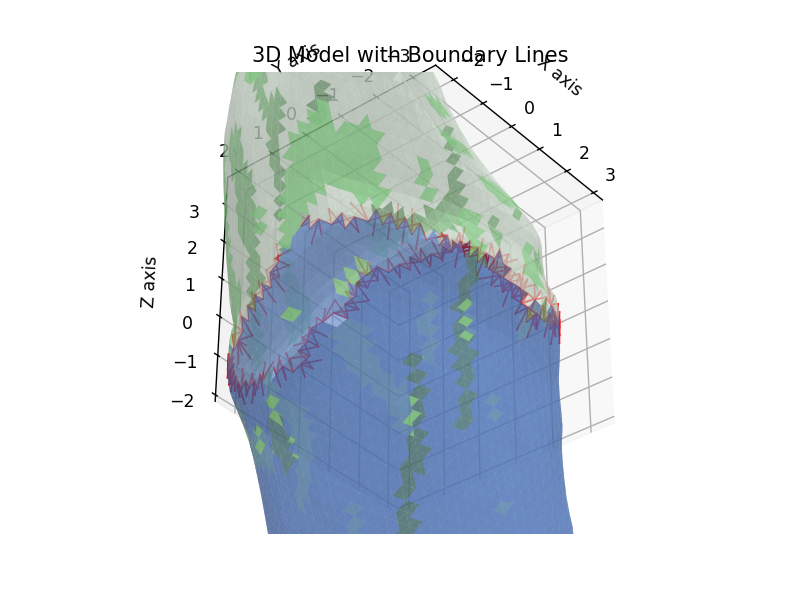

In [7]:
import numpy as np
import tensorflow as tf
from scipy.ndimage import zoom
from scipy.ndimage import grey_dilation, grey_erosion, grey_closing, grey_opening
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection


def load_obj_file(file_path):
    vertices = []
    faces = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):
                vertices.append(list(map(float, line.strip().split()[1:])))
            elif line.startswith('f '):
                faces.append([int(idx.split('/')[0]) - 1 for idx in line.strip().split()[1:]])
    return np.array(vertices), np.array(faces)

def center_vertices(vertices):
    centroid = np.mean(vertices, axis=0)
    return vertices - centroid

def create_voxel_grid(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.int32)
    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]] += 1
    
    return voxel_grid, min_coords, voxel_dim

def get_probabilities_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    
    # predictions should have shape (1, grid_size, grid_size, grid_size, num_classes)
    # Remove batch dimension
    probabilities = np.squeeze(predictions, axis=0)  # Shape: (grid_size, grid_size, grid_size, num_classes)
    
    return probabilities

def upscale_voxel_grid_and_probs(voxel_grid, probs, new_grid_size):
    old_size = voxel_grid.shape[0]
    scale_factor = new_grid_size / old_size

    # 使用最近邻插值来放大二进制体素网格
    new_voxel_grid = zoom(voxel_grid, zoom=scale_factor, order=0)  # 使用最近邻插值

    # 放大概率
    num_classes = probs.shape[-1]
    upscaled_probs = np.zeros((new_grid_size, new_grid_size, new_grid_size, num_classes), dtype=np.float32)
    
    for i in range(num_classes):
        prob_class = probs[..., i]
        prob_class_upscaled = zoom(prob_class, zoom=scale_factor, order=3)  # 使用三次插值
        upscaled_probs[..., i] = prob_class_upscaled

    return new_voxel_grid, upscaled_probs


'''
自定义形态学操作
'''
def generalized_closing(prob_class, dilation_iterations, erosion_iterations, structure_size):
    """
    执行广义闭运算：多次膨胀后多次腐蚀。
    :param prob_class: 概率图的某一类别，形状为 (grid_size, grid_size, grid_size)
    :param dilation_iterations: 膨胀的次数
    :param erosion_iterations: 腐蚀的次数
    :param structure_size: 结构元素的大小
    :return: 广义闭运算后的概率图
    """
    structure = np.ones((structure_size, structure_size, structure_size))
    
    # 多次膨胀
    for _ in range(dilation_iterations):
        prob_class = grey_dilation(prob_class, structure=structure)
    
    # 多次腐蚀
    for _ in range(erosion_iterations):
        prob_class = grey_erosion(prob_class, structure=structure)
    
    return prob_class

def generalized_opening(prob_class, opening_iterations, structure_size):
    """
    执行广义开运算：多次开运算迭代。
    :param prob_class: 概率图的某一类别，形状为 (grid_size, grid_size, grid_size)
    :param opening_iterations: 开运算的次数
    :param structure_size: 结构元素的大小
    :return: 广义开运算后的概率图
    """
    structure = np.ones((structure_size, structure_size, structure_size))
    
    # 多次开运算
    for _ in range(opening_iterations):
        prob_class = grey_opening(prob_class, structure=structure)
    
    return prob_class

def morphological_adjustment(probabilities, labels, dilation_iterations, erosion_iterations, opening_iterations, structure_size, adjustment_iterations):
    """
    对指定标签的概率进行形态学调整：先执行广义闭运算，再执行广义开运算。
    
    :param probabilities: 概率图，形状为 (grid_size, grid_size, grid_size, num_classes)
    :param labels: 要进行形态学调整的标签列表
    :param dilation_iterations: 每阶段膨胀的次数
    :param erosion_iterations: 每阶段腐蚀的次数
    :param opening_iterations: 开运算的次数
    :param structure_size: 结构元素的大小，定义为立方体的边长
    :param adjustment_iterations: 广义闭运算和广义开运算的循环次数
    :return: 形态学调整后的概率图
    """
    num_classes = probabilities.shape[-1]
    adjusted_probabilities = np.copy(probabilities)
    
    for _ in range(adjustment_iterations):
        for label in labels:
            prob_class = adjusted_probabilities[..., label]
            
            # 执行广义闭运算
            prob_class = generalized_closing(prob_class, dilation_iterations, erosion_iterations, structure_size)
            
            # 执行广义开运算
            prob_class = generalized_opening(prob_class, opening_iterations, structure_size)
            
            adjusted_probabilities[..., label] = prob_class
    
    return adjusted_probabilities



def apply_labels_to_point_cloud(data, predicted_probabilities, min_coords, original_voxel_dim, original_grid_size, new_grid_size):
    labels = np.zeros(len(data))
    # 重新计算放大后的体素维度
    voxel_dim = (original_voxel_dim * original_grid_size) / new_grid_size
    
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, new_grid_size-1)
        labels[i] = np.argmax(predicted_probabilities[voxel[0], voxel[1], voxel[2]])
    return labels

def build_topology_graph(vertices, k=10):

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(vertices)
    distances, indices = nbrs.kneighbors(vertices)
    
    G = nx.Graph()
    for i, neighbors in enumerate(indices):
        for j in neighbors:
            if i != j:
                G.add_edge(i, j)
                
    return G

def largest_connected_component(G, nodes):
    subgraph = G.subgraph(nodes)
    largest_cc = max(nx.connected_components(subgraph), key=len)
    return subgraph.subgraph(largest_cc)

def get_max_connected_subgraphs(G, labels, target_labels):
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, l in enumerate(labels) if l == label]
        if nodes:
            largest_cc = largest_connected_component(G, nodes)
            subgraphs[label] = largest_cc
    return subgraphs

def find_boundary_edges(G, subgraph1, subgraph2):
    boundary_edges = []
    for edge in G.edges():
        if (edge[0] in subgraph1 and edge[1] in subgraph2) or (edge[0] in subgraph2 and edge[1] in subgraph1):
            boundary_edges.append(edge)
    return boundary_edges

def plot_surface_with_boundary_lines(vertices, faces, labels, boundary_edges, view_angles=(30, 30), angles=(0, 0, 0)):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.art3d import Line3DCollection

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T
    
    # 绘制不同标签区域的点云
    colors = ['lightgreen', 'cornflowerblue', 'honeydew']
    for i in range(3):
        part_faces = [face for face in faces if sum(labels[vertex] == i for vertex in face) > 1]
        if len(part_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part_faces, color=colors[i], alpha=0.6)
    
    # 绘制边界线
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red', lw=1)
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T


# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/15/15_1.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
original_grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, original_voxel_dim = create_voxel_grid(np.array(centered_vertices), original_grid_size)

# 使用训练好的模型进行预测
predicted_probabilities = get_probabilities_from_model(model, voxel_grid)
print("Shape of predicted_probabilities:", predicted_probabilities.shape)
print("Unique values in predicted_probabilities:", np.unique(predicted_probabilities))

# 等比扩大体素网格
new_grid_size = 80  # <64 时边缘带阶梯形，>128 时面上带洞
upscaled_voxel_grid, upscaled_probabilities = upscale_voxel_grid_and_probs(voxel_grid, predicted_probabilities, new_grid_size)
print("Shape of upscaled_voxel_grid:", upscaled_voxel_grid.shape)
print("Shape of upscaled_probabilities:", upscaled_probabilities.shape)
print("Unique values in upscaled_probabilities:", np.unique(upscaled_probabilities))


# 形态学操作
# 定义膨胀和腐蚀的次数
structure_size = 3  # 结构元素的大小，大于等于3，越大越快越粗糙，因此必须调最小
dilation_iterations = 10  # 每阶段膨胀的次数，决定了能填多大的洞，也决定了边缘会受多大影响
erosion_iterations = 10  # 每阶段腐蚀的次数，同上，应当在不影响边缘精度的条件下尽可能大
opening_iterations = 5  # 广义开运算中开运算的迭代次数，越多边缘越细，5以上区别不明显
adjustment_iterations = 1  # 广义闭运算和开运算的循环次数，没啥影响，越大越慢所以取最小值1
# 对上采样后的概率进行形态学调整
adjusted_probabilities = morphological_adjustment(upscaled_probabilities, labels=[1, 2], 
                                                  dilation_iterations=dilation_iterations, erosion_iterations=erosion_iterations, 
                                                  opening_iterations=opening_iterations, 
                                                  structure_size=structure_size, adjustment_iterations=adjustment_iterations)
# print("Shape of adjusted_probabilities:", adjusted_probabilities.shape)
# print("Unique values in adjusted_probabilities:", np.unique(adjusted_probabilities))

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(centered_vertices, adjusted_probabilities, min_coords, original_voxel_dim, original_grid_size, new_grid_size)
# print("Shape of predicted_point_labels:", predicted_point_labels.shape)
# print("Predicted_point_labels:", predicted_point_labels)
# print("Unique values in predicted_point_labels:", np.unique(predicted_point_labels))


# 构建拓扑图
G = build_topology_graph(centered_vertices)

# 找到最大连通子图
target_labels = [1, 2]
subgraphs = get_max_connected_subgraphs(G, predicted_point_labels, target_labels)

# 找到边界线
boundary_edges = find_boundary_edges(G, subgraphs[1], subgraphs[2])
# print('Boundary:', boundary_edges)

# 绘制点云及边界线
plot_surface_with_boundary_lines(centered_vertices, faces, predicted_point_labels, boundary_edges, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))

In [12]:
'''
轮廓线重建
先做中心提取，再拟合曲线

# 开启交互旋转
%matplotlib widget
'''

'\n轮廓线重建\n先做中心提取，再拟合曲线\n\n# 开启交互旋转\n%matplotlib widget\n'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Shape of predicted_probabilities: (16, 16, 16, 3)
Unique values in predicted_probabilities: [0.0000000e+00 2.3888577e-38 2.4525705e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
Shape of upscaled_voxel_grid: (80, 80, 80)
Shape of upscaled_probabilities: (80, 80, 80, 3)
Unique values in upscaled_probabilities: [-0.38059872 -0.3679185  -0.36771917 ...  1.4094043   1.4245443
  1.4380193 ]


<IPython.core.display.Javascript object>


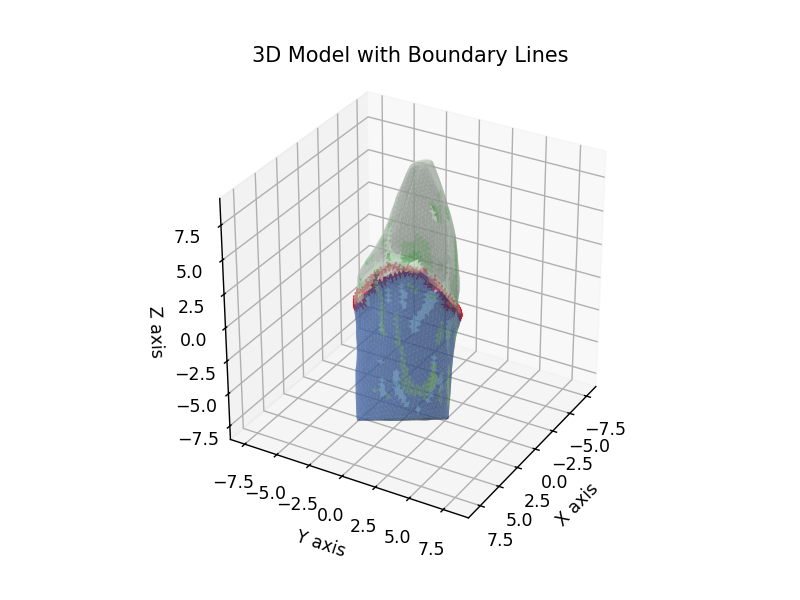

In [9]:
import numpy as np
import tensorflow as tf
from scipy.ndimage import zoom
from scipy.ndimage import grey_dilation, grey_erosion, grey_closing, grey_opening
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection


def load_obj_file(file_path):
    vertices = []
    faces = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):
                vertices.append(list(map(float, line.strip().split()[1:])))
            elif line.startswith('f '):
                faces.append([int(idx.split('/')[0]) - 1 for idx in line.strip().split()[1:]])
    return np.array(vertices), np.array(faces)

def center_vertices(vertices):
    centroid = np.mean(vertices, axis=0)
    return vertices - centroid

def create_voxel_grid(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.int32)
    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]] += 1
    
    return voxel_grid, min_coords, voxel_dim

def get_probabilities_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    
    # predictions should have shape (1, grid_size, grid_size, grid_size, num_classes)
    # Remove batch dimension
    probabilities = np.squeeze(predictions, axis=0)  # Shape: (grid_size, grid_size, grid_size, num_classes)
    
    return probabilities

def upscale_voxel_grid_and_probs(voxel_grid, probs, new_grid_size):
    old_size = voxel_grid.shape[0]
    scale_factor = new_grid_size / old_size

    # 使用最近邻插值来放大二进制体素网格
    new_voxel_grid = zoom(voxel_grid, zoom=scale_factor, order=0)  # 使用最近邻插值

    # 放大概率
    num_classes = probs.shape[-1]
    upscaled_probs = np.zeros((new_grid_size, new_grid_size, new_grid_size, num_classes), dtype=np.float32)
    
    for i in range(num_classes):
        prob_class = probs[..., i]
        prob_class_upscaled = zoom(prob_class, zoom=scale_factor, order=3)  # 使用三次插值
        upscaled_probs[..., i] = prob_class_upscaled

    return new_voxel_grid, upscaled_probs


'''
自定义形态学操作
'''
def generalized_closing(prob_class, dilation_iterations, erosion_iterations, structure_size):
    """
    执行广义闭运算：多次膨胀后多次腐蚀。
    :param prob_class: 概率图的某一类别，形状为 (grid_size, grid_size, grid_size)
    :param dilation_iterations: 膨胀的次数
    :param erosion_iterations: 腐蚀的次数
    :param structure_size: 结构元素的大小
    :return: 广义闭运算后的概率图
    """
    structure = np.ones((structure_size, structure_size, structure_size))
    
    # 多次膨胀
    for _ in range(dilation_iterations):
        prob_class = grey_dilation(prob_class, structure=structure)
    
    # 多次腐蚀
    for _ in range(erosion_iterations):
        prob_class = grey_erosion(prob_class, structure=structure)
    
    return prob_class

def generalized_opening(prob_class, opening_iterations, structure_size):
    """
    执行广义开运算：多次开运算迭代。
    :param prob_class: 概率图的某一类别，形状为 (grid_size, grid_size, grid_size)
    :param opening_iterations: 开运算的次数
    :param structure_size: 结构元素的大小
    :return: 广义开运算后的概率图
    """
    structure = np.ones((structure_size, structure_size, structure_size))
    
    # 多次开运算
    for _ in range(opening_iterations):
        prob_class = grey_opening(prob_class, structure=structure)
    
    return prob_class

def morphological_adjustment(probabilities, labels, dilation_iterations, erosion_iterations, opening_iterations, structure_size, adjustment_iterations):
    """
    对指定标签的概率进行形态学调整：先执行广义闭运算，再执行广义开运算。
    
    :param probabilities: 概率图，形状为 (grid_size, grid_size, grid_size, num_classes)
    :param labels: 要进行形态学调整的标签列表
    :param dilation_iterations: 每阶段膨胀的次数
    :param erosion_iterations: 每阶段腐蚀的次数
    :param opening_iterations: 开运算的次数
    :param structure_size: 结构元素的大小，定义为立方体的边长
    :param adjustment_iterations: 广义闭运算和广义开运算的循环次数
    :return: 形态学调整后的概率图
    """
    num_classes = probabilities.shape[-1]
    adjusted_probabilities = np.copy(probabilities)
    
    for _ in range(adjustment_iterations):
        for label in labels:
            prob_class = adjusted_probabilities[..., label]
            
            # 执行广义闭运算
            prob_class = generalized_closing(prob_class, dilation_iterations, erosion_iterations, structure_size)
            
            # 执行广义开运算
            prob_class = generalized_opening(prob_class, opening_iterations, structure_size)
            
            adjusted_probabilities[..., label] = prob_class
    
    return adjusted_probabilities



def apply_labels_to_point_cloud(data, predicted_probabilities, min_coords, original_voxel_dim, original_grid_size, new_grid_size):
    labels = np.zeros(len(data))
    # 重新计算放大后的体素维度
    voxel_dim = (original_voxel_dim * original_grid_size) / new_grid_size
    
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, new_grid_size-1)
        labels[i] = np.argmax(predicted_probabilities[voxel[0], voxel[1], voxel[2]])
    return labels


def build_topology_graph(vertices, k=10):

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(vertices)
    distances, indices = nbrs.kneighbors(vertices)
    
    G = nx.Graph()
    for i, neighbors in enumerate(indices):
        for j in neighbors:
            if i != j:
                G.add_edge(i, j)
                
    return G

def largest_connected_component(G, nodes):
    subgraph = G.subgraph(nodes)
    largest_cc = max(nx.connected_components(subgraph), key=len)
    return subgraph.subgraph(largest_cc)

def get_max_connected_subgraphs(G, labels, target_labels):
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, l in enumerate(labels) if l == label]
        if nodes:
            largest_cc = largest_connected_component(G, nodes)
            subgraphs[label] = largest_cc
    return subgraphs

def find_boundary_edges(G, subgraph1, subgraph2):
    boundary_edges = []
    for edge in G.edges():
        if (edge[0] in subgraph1 and edge[1] in subgraph2) or (edge[0] in subgraph2 and edge[1] in subgraph1):
            boundary_edges.append(edge)
    return boundary_edges

def plot_surface_with_boundary_lines(vertices, faces, labels, boundary_edges, view_angles=(30, 30), angles=(0, 0, 0)):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T
    
    # 绘制不同标签区域的点云
    colors = ['lightgreen', 'cornflowerblue', 'honeydew']
    for i in range(3):
        part_faces = [face for face in faces if sum(labels[vertex] == i for vertex in face) > 1]
        if len(part_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part_faces, color=colors[i], alpha=0.6)
    
    # 绘制边界线
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red', lw=1)
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T


# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/15/15_1.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
original_grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, original_voxel_dim = create_voxel_grid(np.array(centered_vertices), original_grid_size)

# 使用训练好的模型进行预测
predicted_probabilities = get_probabilities_from_model(model, voxel_grid)
print("Shape of predicted_probabilities:", predicted_probabilities.shape)
print("Unique values in predicted_probabilities:", np.unique(predicted_probabilities))

# 等比扩大体素网格
new_grid_size = 80  # <64 时边缘带阶梯形，>128 时面上带洞
upscaled_voxel_grid, upscaled_probabilities = upscale_voxel_grid_and_probs(voxel_grid, predicted_probabilities, new_grid_size)
print("Shape of upscaled_voxel_grid:", upscaled_voxel_grid.shape)
print("Shape of upscaled_probabilities:", upscaled_probabilities.shape)
print("Unique values in upscaled_probabilities:", np.unique(upscaled_probabilities))


# 形态学操作
# 定义膨胀和腐蚀的次数
structure_size = 3  # 结构元素的大小，大于等于3，越大越快越粗糙，因此必须调最小
dilation_iterations = 10  # 每阶段膨胀的次数，决定了能填多大的洞，也决定了边缘会受多大影响
erosion_iterations = 10  # 每阶段腐蚀的次数，同上，应当在不影响边缘精度的条件下尽可能大
opening_iterations = 5  # 广义开运算中开运算的迭代次数，越多边缘越细，5以上区别不明显
adjustment_iterations = 1  # 广义闭运算和开运算的循环次数，没啥影响，越大越慢所以取最小值1
# 对上采样后的概率进行形态学调整
adjusted_probabilities = morphological_adjustment(upscaled_probabilities, labels=[1, 2], 
                                                  dilation_iterations=dilation_iterations, erosion_iterations=erosion_iterations, 
                                                  opening_iterations=opening_iterations, 
                                                  structure_size=structure_size, adjustment_iterations=adjustment_iterations)
# print("Shape of adjusted_probabilities:", adjusted_probabilities.shape)
# print("Unique values in adjusted_probabilities:", np.unique(adjusted_probabilities))

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(centered_vertices, adjusted_probabilities, min_coords, original_voxel_dim, original_grid_size, new_grid_size)
# print("Shape of predicted_point_labels:", predicted_point_labels.shape)
# print("Predicted_point_labels:", predicted_point_labels)
# print("Unique values in predicted_point_labels:", np.unique(predicted_point_labels))


# 构建拓扑图
G = build_topology_graph(centered_vertices)

# 找到最大连通子图
target_labels = [1, 2]
subgraphs = get_max_connected_subgraphs(G, predicted_point_labels, target_labels)

# 找到边界线
boundary_edges = find_boundary_edges(G, subgraphs[1], subgraphs[2])
# print('Boundary:', boundary_edges)

# 绘制点云及边界线
plot_surface_with_boundary_lines(centered_vertices, faces, predicted_point_labels, boundary_edges, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))

In [ ]:
'''
轮廓线重建
'''



<IPython.core.display.Javascript object>


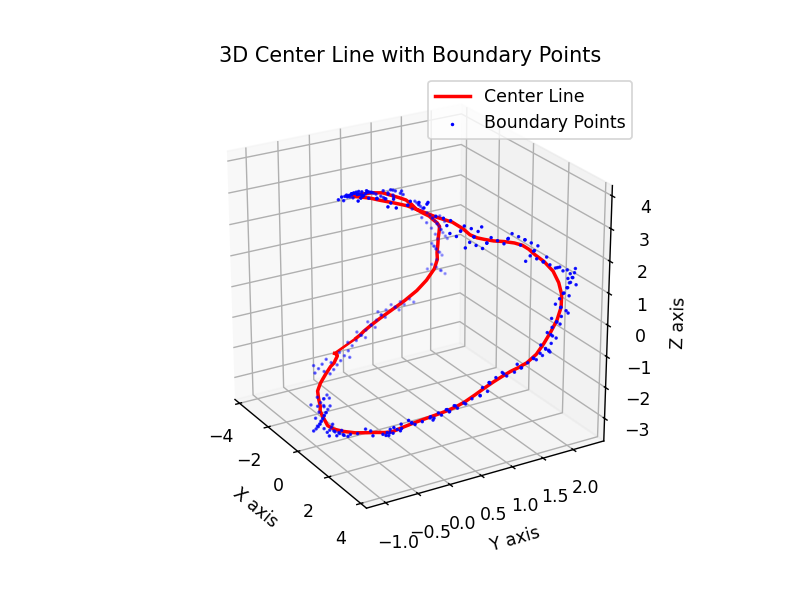

100


In [72]:
'''
局部加权平滑
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.spatial import distance_matrix


# 局部加权平滑函数
def local_weighted_smooth(x, y, z, window_size=5, sigma=1.0):
    def smooth1d(data, window_size, sigma):
        smoothed = np.copy(data)
        for i in range(len(data)):
            start = max(0, i - window_size // 2)
            end = min(len(data), i + window_size // 2 + 1)
            weights = np.exp(-0.5 * ((np.arange(start, end) - i) ** 2) / sigma ** 2)
            weights /= weights.sum()
            smoothed[i] = np.dot(weights, data[start:end])
        return smoothed

    x_smoothed = smooth1d(x, window_size, sigma)
    y_smoothed = smooth1d(y, window_size, sigma)
    z_smoothed = smooth1d(z, window_size, sigma)
    
    return x_smoothed, y_smoothed, z_smoothed

# 计算边界线中点
def calculate_midpoints(boundary_edges, vertices):
    midpoints = []
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        midpoint = (p1 + p2) / 2
        midpoints.append(midpoint)
    return np.array(midpoints)

# 创建体素网格
def create_voxel_grid_for_boundary(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=object)
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                voxel_grid[i, j, k] = []

    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]].append(point)
    
    return voxel_grid, min_coords, voxel_dim

# 计算体素重心
def calculate_voxel_centroids(voxel_grid, grid_size):
    centroids = []
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                points_in_voxel = voxel_grid[i, j, k]
                if points_in_voxel:
                    centroid = np.mean(points_in_voxel, axis=0)
                    centroids.append(centroid)
    return np.array(centroids)

# 通过最近邻方法排序点
def order_points(points):
    if len(points) < 2:
        return points
    
    n = points.shape[0]
    ordered_points = [points[0]]
    visited = {0}
    
    for _ in range(1, n):
        last_point = ordered_points[-1].reshape(1, -1)
        distances = distance_matrix(last_point, points)[0]
        distances[list(visited)] = np.inf
        next_point_index = np.argmin(distances)
        visited.add(next_point_index)
        ordered_points.append(points[next_point_index])
    
    return np.array(ordered_points)

# 拟合平滑曲线
def fit_smooth_curve(points, num_points=100, smooth_factor=1.0, window_size=5):
    if len(points) < 2:
        return points
    
    ordered_points = order_points(points)
    
    x = ordered_points[:, 0]
    y = ordered_points[:, 1]
    z = ordered_points[:, 2]
    
    t = np.arange(len(x))
    
    # Ensure the curve is closed by adding the first point at the end
    x = np.concatenate([x, [x[0]]])
    y = np.concatenate([y, [y[0]]])
    z = np.concatenate([z, [z[0]]])
    t = np.concatenate([t, [t[-1] + 1]])
    
    # Fit cubic spline with periodic boundary conditions
    cs_x = CubicSpline(t, x, bc_type='periodic')
    cs_y = CubicSpline(t, y, bc_type='periodic')
    cs_z = CubicSpline(t, z, bc_type='periodic')
    
    t_new = np.linspace(0, len(t) - 1, num=num_points)
    x_new = cs_x(t_new)
    y_new = cs_y(t_new)
    z_new = cs_z(t_new)
    
    # Apply local weighted smoothing
    x_smoothed, y_smoothed, z_smoothed = local_weighted_smooth(x_new, y_new, z_new, window_size, smooth_factor)
    
    return np.vstack([x_smoothed, y_smoothed, z_smoothed]).T

# 绘制中心线
def plot_center_line(center_line, boundary_midpoints, view_angles=(30, 30)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x, y, z = center_line.T
    ax.plot(x, y, z, color='red', lw=2, label='Center Line')
    
    # Draw line connecting the start and end points
    ax.plot([x[0], x[-1]], [y[0], y[-1]], [z[0], z[-1]], color='r', linestyle='-')
    
    bx, by, bz = boundary_midpoints.T
    ax.scatter(bx, by, bz, color='blue', s=1, label='Boundary Points')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Center Line with Boundary Points')

    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)

    ax.set_box_aspect([1,1,1])

    plt.legend()
    plt.show()
    

# 主程序
boundary_midpoints = calculate_midpoints(boundary_edges, centered_vertices)
grid_size = 10
voxel_grid, min_coords, voxel_dim = create_voxel_grid_for_boundary(boundary_midpoints, grid_size)
voxel_centroids = calculate_voxel_centroids(voxel_grid, grid_size)

if len(voxel_centroids) < 2:
    raise ValueError("Not enough points to fit a smooth curve.")

# smooth_factor越大，平均带越宽、曲线越平滑，大于2以后结果趋于稳定；window size是每个像素处的参考点数，太小无效，太大丢细节
smooth_center_line = fit_smooth_curve(voxel_centroids, smooth_factor=3, window_size=5)  
plot_center_line(smooth_center_line, boundary_midpoints)


<IPython.core.display.Javascript object>


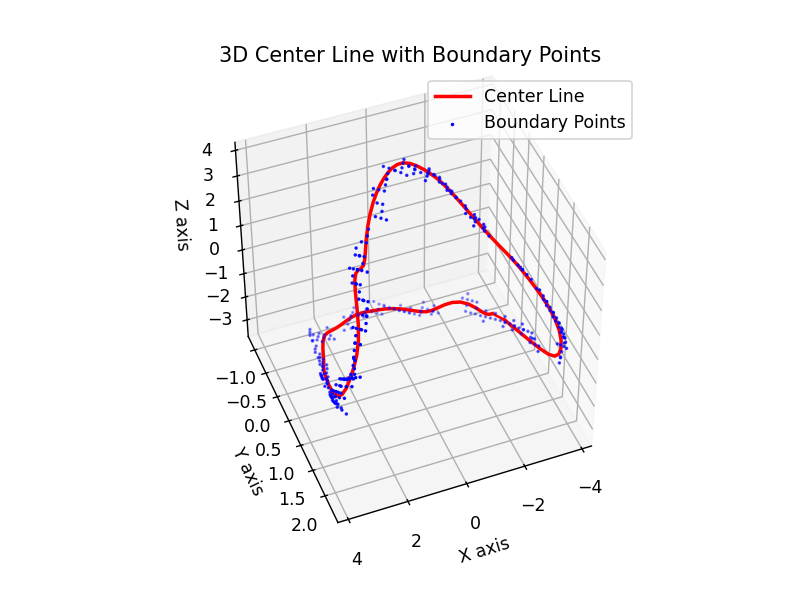

In [69]:
'''
RDP采样+高斯滤波
相较局部加权平滑来说更平滑，但也更容易失真
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.spatial import distance_matrix
from scipy.ndimage import gaussian_filter1d
from typing import List

# Ramer-Douglas-Peucker Algorithm for simplifying points
def rdp(points: np.ndarray, epsilon: float) -> np.ndarray:
    def perpendicular_distance(point: np.ndarray, line_start: np.ndarray, line_end: np.ndarray) -> float:
        return np.linalg.norm(np.cross(line_end - line_start, line_start - point)) / np.linalg.norm(line_end - line_start)
    
    def rdp_rec(points: List[np.ndarray], epsilon: float) -> List[np.ndarray]:
        if len(points) < 2:
            return points

        start, end = points[0], points[-1]
        max_dist = 0
        index = 0

        for i in range(1, len(points) - 1):
            dist = perpendicular_distance(points[i], start, end)
            if dist > max_dist:
                max_dist = dist
                index = i
        
        if max_dist > epsilon:
            rec_results1 = rdp_rec(points[:index+1], epsilon)
            rec_results2 = rdp_rec(points[index:], epsilon)
            return rec_results1[:-1] + rec_results2
        else:
            return [start, end]

    return np.array(rdp_rec(list(points), epsilon))

# 计算边界线中点
def calculate_midpoints(boundary_edges, vertices):
    midpoints = []
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        midpoint = (p1 + p2) / 2
        midpoints.append(midpoint)
    return np.array(midpoints)

# 创建体素网格
def create_voxel_grid_for_boundary(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=object)
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                voxel_grid[i, j, k] = []

    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]].append(point)
    
    return voxel_grid, min_coords, voxel_dim

# 计算体素重心
def calculate_voxel_centroids(voxel_grid, grid_size):
    centroids = []
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                points_in_voxel = voxel_grid[i, j, k]
                if points_in_voxel:
                    centroid = np.mean(points_in_voxel, axis=0)
                    centroids.append(centroid)
    return np.array(centroids)

# 通过最近邻方法排序点
def order_points(points):
    if len(points) < 2:
        return points
    
    n = points.shape[0]
    ordered_points = [points[0]]
    visited = {0}
    
    for _ in range(1, n):
        last_point = ordered_points[-1].reshape(1, -1)
        distances = distance_matrix(last_point, points)[0]
        distances[list(visited)] = np.inf
        next_point_index = np.argmin(distances)
        visited.add(next_point_index)
        ordered_points.append(points[next_point_index])
    
    return np.array(ordered_points)

# 拟合平滑曲线
def fit_smooth_curve(points, num_points=100, smooth_factor=0.05, epsilon=0.5):
    if len(points) < 2:
        return points
    
    # 使用RDP算法简化点
    simplified_points = rdp(points, epsilon)
    
    ordered_points = order_points(simplified_points)
    
    x = ordered_points[:, 0]
    y = ordered_points[:, 1]
    z = ordered_points[:, 2]
    
    t = np.arange(len(x))
    
    # Ensure the curve is closed by adding the first point at the end
    x = np.concatenate([x, [x[0]]])
    y = np.concatenate([y, [y[0]]])
    z = np.concatenate([z, [z[0]]])
    t = np.concatenate([t, [t[-1] + 1]])
    
    # Fit cubic spline with periodic boundary conditions for closure
    cs_x = CubicSpline(t, x, bc_type='periodic')
    cs_y = CubicSpline(t, y, bc_type='periodic')
    cs_z = CubicSpline(t, z, bc_type='periodic')
    
    t_new = np.linspace(0, len(t) - 1, num=num_points)
    x_new = cs_x(t_new)
    y_new = cs_y(t_new)
    z_new = cs_z(t_new)
    
    # Apply Gaussian filter to smooth the curve
    x_smoothed = gaussian_filter1d(x_new, sigma=smooth_factor)
    y_smoothed = gaussian_filter1d(y_new, sigma=smooth_factor)
    z_smoothed = gaussian_filter1d(z_new, sigma=smooth_factor)
    
    return np.vstack([x_smoothed, y_smoothed, z_smoothed]).T, simplified_points

# 绘制中心线
def plot_center_line(center_line, boundary_midpoints, view_angles=(30, 30)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x, y, z = center_line.T
    ax.plot(x, y, z, color='red', lw=2, label='Center Line')
    
    # Draw line connecting the start and end points
    ax.plot([x[0], x[-1]], [y[0], y[-1]], [z[0], z[-1]], color='r', linestyle='-')
    
    bx, by, bz = boundary_midpoints.T
    ax.scatter(bx, by, bz, color='blue', s=1, label='Boundary Points')
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Center Line with Boundary Points')

    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)

    ax.set_box_aspect([1,1,1])

    plt.legend()
    plt.show()

# 主程序
boundary_midpoints = calculate_midpoints(boundary_edges, centered_vertices)
grid_size = 10
voxel_grid, min_coords, voxel_dim = create_voxel_grid_for_boundary(boundary_midpoints, grid_size)
voxel_centroids = calculate_voxel_centroids(voxel_grid, grid_size)

if len(voxel_centroids) < 2:
    raise ValueError("Not enough points to fit a smooth curve.")

# smooth_factor是高斯滤波的平滑因子，同上——也是个sigma;效果不好，<1 时效果不明显,>2 时会失真
# epsilon 控制简化点云时允许的最大距离误差，值越大，简化后的点云就越少，曲线就越平滑，但可能会丢失一些细节；<0.5 会有锯齿，>0.6 会失真
smooth_center_line, simplified_points = fit_smooth_curve(voxel_centroids, smooth_factor=1.5, epsilon=0.5)
plot_center_line(smooth_center_line, boundary_midpoints)


74
74


<IPython.core.display.Javascript object>


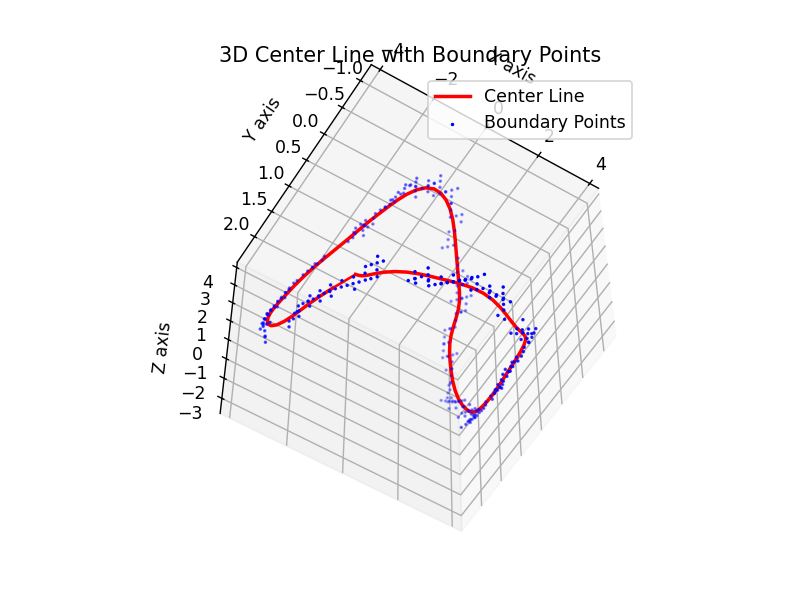

'\n参数太多，不好调\n采样没用，点数25-74最终曲线没变化\n滤波有用，能去掉高频\n'

In [97]:
'''
融合上述两种算法
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.spatial import distance_matrix
from scipy.ndimage import gaussian_filter1d
from typing import List


# Ramer-Douglas-Peucker Algorithm for simplifying points
def rdp(points: np.ndarray, epsilon: float) -> np.ndarray:
    def perpendicular_distance(point: np.ndarray, line_start: np.ndarray, line_end: np.ndarray) -> float:
        return np.linalg.norm(np.cross(line_end - line_start, line_start - point)) / np.linalg.norm(line_end - line_start)
    
    def rdp_rec(points: List[np.ndarray], epsilon: float) -> List[np.ndarray]:
        if len(points) < 2:
            return points

        start, end = points[0], points[-1]
        max_dist = 0
        index = 0

        for i in range(1, len(points) - 1):
            dist = perpendicular_distance(points[i], start, end)
            if dist > max_dist:
                max_dist = dist
                index = i
        
        if max_dist > epsilon:
            rec_results1 = rdp_rec(points[:index+1], epsilon)
            rec_results2 = rdp_rec(points[index:], epsilon)
            return rec_results1[:-1] + rec_results2
        else:
            return [start, end]

    return np.array(rdp_rec(list(points), epsilon))

# 局部加权平滑函数
def local_weighted_smooth(x, y, z, window_size=5, sigma=1.0):
    def smooth1d(data, window_size, sigma):
        smoothed = np.copy(data)
        for i in range(len(data)):
            start = max(0, i - window_size // 2)
            end = min(len(data), i + window_size // 2 + 1)
            weights = np.exp(-0.5 * ((np.arange(start, end) - i) ** 2) / sigma ** 2)
            weights /= weights.sum()
            smoothed[i] = np.dot(weights, data[start:end])
        return smoothed

    x_smoothed = smooth1d(x, window_size, sigma)
    y_smoothed = smooth1d(y, window_size, sigma)
    z_smoothed = smooth1d(z, window_size, sigma)
    
    return x_smoothed, y_smoothed, z_smoothed

# 计算边界线中点
def calculate_midpoints(boundary_edges, vertices):
    midpoints = []
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        midpoint = (p1 + p2) / 2
        midpoints.append(midpoint)
    return np.array(midpoints)

# 创建体素网格
def create_voxel_grid_for_boundary(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=object)
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                voxel_grid[i, j, k] = []

    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]].append(point)
    
    return voxel_grid, min_coords, voxel_dim

# 计算体素重心
def calculate_voxel_centroids(voxel_grid, grid_size):
    centroids = []
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                points_in_voxel = voxel_grid[i, j, k]
                if points_in_voxel:
                    centroid = np.mean(points_in_voxel, axis=0)
                    centroids.append(centroid)
    return np.array(centroids)

# 通过最近邻方法排序点
def order_points(points):
    if len(points) < 2:
        return points
    
    n = points.shape[0]
    ordered_points = [points[0]]
    visited = {0}
    
    for _ in range(1, n):
        last_point = ordered_points[-1].reshape(1, -1)
        distances = distance_matrix(last_point, points)[0]
        distances[list(visited)] = np.inf
        next_point_index = np.argmin(distances)
        visited.add(next_point_index)
        ordered_points.append(points[next_point_index])
    
    return np.array(ordered_points)

# 拟合平滑曲线
def fit_smooth_curve(points, num_points=100, smooth_factor1=0.05, epsilon=0.5, smooth_factor2=3, window_size=5):
    if len(points) < 2:
        return points
    
    # 使用RDP算法简化点
    simplified_points = rdp(points, epsilon)
    print(len(points))
    print(len(simplified_points))
    
    ordered_points = order_points(simplified_points)
    
    x = ordered_points[:, 0]
    y = ordered_points[:, 1]
    z = ordered_points[:, 2]
    
    t = np.arange(len(x))
    
    # Ensure the curve is closed by adding the first point at the end
    x = np.concatenate([x, [x[0]]])
    y = np.concatenate([y, [y[0]]])
    z = np.concatenate([z, [z[0]]])
    t = np.concatenate([t, [t[-1] + 1]])
    
    # Fit cubic spline with periodic boundary conditions for closure
    cs_x = CubicSpline(t, x, bc_type='periodic')
    cs_y = CubicSpline(t, y, bc_type='periodic')
    cs_z = CubicSpline(t, z, bc_type='periodic')
    
    t_new = np.linspace(0, len(t) - 1, num=num_points)
    x_new = cs_x(t_new)
    y_new = cs_y(t_new)
    z_new = cs_z(t_new)
    
    # Apply local weighted smoothing
    x_smoothed, y_smoothed, z_smoothed = local_weighted_smooth(x_new, y_new, z_new, window_size, smooth_factor1)
    
    # Apply Gaussian filter to smooth the curve
    x_smoothed = gaussian_filter1d(x_smoothed, sigma=smooth_factor2)
    y_smoothed = gaussian_filter1d(y_smoothed, sigma=smooth_factor2)
    z_smoothed = gaussian_filter1d(z_smoothed, sigma=smooth_factor2)
    
    return np.vstack([x_smoothed, y_smoothed, z_smoothed]).T, simplified_points

# 绘制中心线
def plot_center_line(center_line, boundary_midpoints, view_angles=(30, 30)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x, y, z = center_line.T
    ax.plot(x, y, z, color='red', lw=2, label='Center Line')
    
    # Draw line connecting the start and end points
    ax.plot([x[0], x[-1]], [y[0], y[-1]], [z[0], z[-1]], color='r', linestyle='-')
    
    bx, by, bz = boundary_midpoints.T
    ax.scatter(bx, by, bz, color='blue', s=1, label='Boundary Points')
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Center Line with Boundary Points')

    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)

    ax.set_box_aspect([1,1,1])

    plt.legend()
    plt.show()

# 主程序
boundary_midpoints = calculate_midpoints(boundary_edges, centered_vertices)
grid_size = 10
voxel_grid, min_coords, voxel_dim = create_voxel_grid_for_boundary(boundary_midpoints, grid_size)
voxel_centroids = calculate_voxel_centroids(voxel_grid, grid_size)

if len(voxel_centroids) < 2:
    raise ValueError("Not enough points to fit a smooth curve.")

# smooth_factor2是高斯滤波的平滑因子，同上——也是个sigma;效果不好，<1 时效果不明显,>2 时会失真
# epsilon 控制简化点云时允许的最大距离误差，值越大，简化后的点云就越少，曲线就越平滑，但可能会丢失一些细节；<0.5 会有锯齿，>0.6 会失真
# smooth_factor1是局部加权平滑因子，值越大，平均带越宽、曲线越平滑，大于2以后结果趋于稳定；window size是每个像素处的参考点数，太小无效，太大丢细节
smooth_center_line, simplified_points = fit_smooth_curve(voxel_centroids, smooth_factor1=0.2, epsilon=0.005, smooth_factor2=2, window_size=1)
plot_center_line(smooth_center_line, boundary_midpoints)

'''
参数太多，不好调
采样没用，点数25-74最终曲线没变化
滤波有用，能去掉高频
'''

<IPython.core.display.Javascript object>


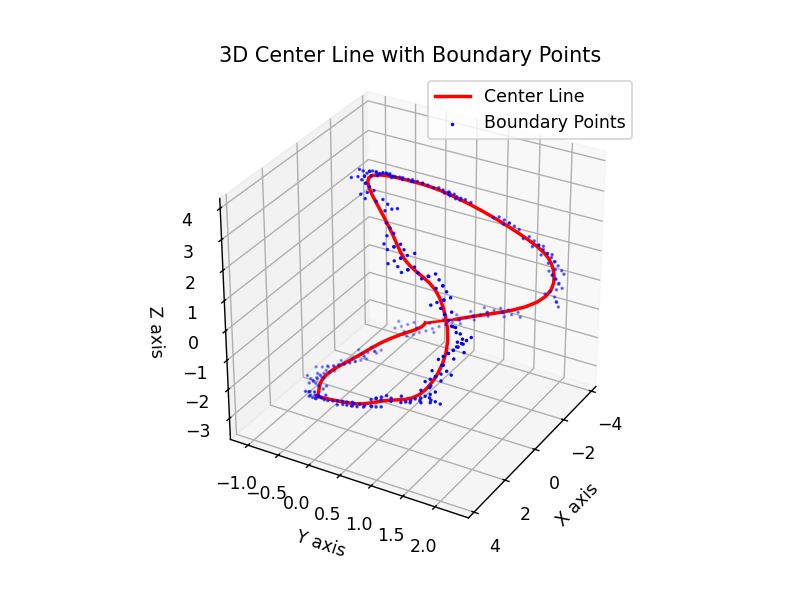

In [107]:
'''
稳定版
局部加权平滑+高斯滤波
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.spatial import distance_matrix
from scipy.ndimage import gaussian_filter1d


# 局部加权平滑函数
def local_weighted_smooth(x, y, z, window_size=5, sigma=1.0):
    def smooth1d(data, window_size, sigma):
        smoothed = np.copy(data)
        for i in range(len(data)):
            start = max(0, i - window_size // 2)
            end = min(len(data), i + window_size // 2 + 1)
            weights = np.exp(-0.5 * ((np.arange(start, end) - i) ** 2) / sigma ** 2)
            weights /= weights.sum()
            smoothed[i] = np.dot(weights, data[start:end])
        return smoothed

    x_smoothed = smooth1d(x, window_size, sigma)
    y_smoothed = smooth1d(y, window_size, sigma)
    z_smoothed = smooth1d(z, window_size, sigma)
    
    return x_smoothed, y_smoothed, z_smoothed

# 计算边界线中点
def calculate_midpoints(boundary_edges, vertices):
    midpoints = []
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        midpoint = (p1 + p2) / 2
        midpoints.append(midpoint)
    return np.array(midpoints)

# 创建体素网格
def create_voxel_grid_for_boundary(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=object)
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                voxel_grid[i, j, k] = []

    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]].append(point)
    
    return voxel_grid, min_coords, voxel_dim

# 计算体素重心
def calculate_voxel_centroids(voxel_grid, grid_size):
    centroids = []
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                points_in_voxel = voxel_grid[i, j, k]
                if points_in_voxel:
                    centroid = np.mean(points_in_voxel, axis=0)
                    centroids.append(centroid)
    return np.array(centroids)

# 通过最近邻方法排序点
def order_points(points):
    if len(points) < 2:
        return points
    
    n = points.shape[0]
    ordered_points = [points[0]]
    visited = {0}
    
    for _ in range(1, n):
        last_point = ordered_points[-1].reshape(1, -1)
        distances = distance_matrix(last_point, points)[0]
        distances[list(visited)] = np.inf
        next_point_index = np.argmin(distances)
        visited.add(next_point_index)
        ordered_points.append(points[next_point_index])
    
    return np.array(ordered_points)

# 拟合平滑曲线
def fit_smooth_curve(points, num_points=100, smooth_factor1=1.0, window_size=5, smooth_factor2=2):
    if len(points) < 2:
        return points
    
    ordered_points = order_points(points)
    
    x = ordered_points[:, 0]
    y = ordered_points[:, 1]
    z = ordered_points[:, 2]
    
    t = np.arange(len(x))
    
    # Ensure the curve is closed by adding the first point at the end
    x = np.concatenate([x, [x[0]]])
    y = np.concatenate([y, [y[0]]])
    z = np.concatenate([z, [z[0]]])
    t = np.concatenate([t, [t[-1] + 1]])
    
    # Fit cubic spline with periodic boundary conditions
    cs_x = CubicSpline(t, x, bc_type='periodic')
    cs_y = CubicSpline(t, y, bc_type='periodic')
    cs_z = CubicSpline(t, z, bc_type='periodic')
    
    t_new = np.linspace(0, len(t) - 1, num=num_points)
    x_new = cs_x(t_new)
    y_new = cs_y(t_new)
    z_new = cs_z(t_new)
    
    # Apply local weighted smoothing
    x_smoothed, y_smoothed, z_smoothed = local_weighted_smooth(x_new, y_new, z_new, window_size, smooth_factor1)
    
    # Apply Gaussian filter to smooth the curve
    x_smoothed = gaussian_filter1d(x_smoothed, sigma=smooth_factor2)
    y_smoothed = gaussian_filter1d(y_smoothed, sigma=smooth_factor2)
    z_smoothed = gaussian_filter1d(z_smoothed, sigma=smooth_factor2)
    
    return np.vstack([x_smoothed, y_smoothed, z_smoothed]).T

# 绘制中心线
def plot_center_line(center_line, boundary_midpoints, view_angles=(30, 30)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x, y, z = center_line.T
    ax.plot(x, y, z, color='red', lw=2, label='Center Line')
    
    # Draw line connecting the start and end points
    ax.plot([x[0], x[-1]], [y[0], y[-1]], [z[0], z[-1]], color='r', linestyle='-')
    
    bx, by, bz = boundary_midpoints.T
    ax.scatter(bx, by, bz, color='blue', s=1, label='Boundary Points')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Center Line with Boundary Points')

    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)

    ax.set_box_aspect([1,1,1])

    plt.legend()
    plt.show()
    

# 主程序
boundary_midpoints = calculate_midpoints(boundary_edges, centered_vertices)
grid_size = 10
voxel_grid, min_coords, voxel_dim = create_voxel_grid_for_boundary(boundary_midpoints, grid_size)
voxel_centroids = calculate_voxel_centroids(voxel_grid, grid_size)

if len(voxel_centroids) < 2:
    raise ValueError("Not enough points to fit a smooth curve.")

# smooth_factor1是局部加权平滑因子，值越大，平均带越宽、曲线越平滑，大于2以后结果趋于稳定；window size是每个像素处的参考点数，太小无效，太大丢细节
# smooth_factor2是高斯滤波的平滑因子，同上——也是个sigma;效果不好，<1 时效果不明显,>2 时会失真
smooth_center_line = fit_smooth_curve(voxel_centroids, smooth_factor1=2, window_size=5, smooth_factor2=1.5)  
plot_center_line(smooth_center_line, boundary_midpoints)


Trying with tolerance: 0.1
Number of inside points: 12
Trying with tolerance: 0.12000000000000001
Number of inside points: 29
Trying with tolerance: 0.14
Number of inside points: 45
Trying with tolerance: 0.16
Number of inside points: 63
Trying with tolerance: 0.18
Number of inside points: 85
Trying with tolerance: 0.19999999999999998
Number of inside points: 105
Trying with tolerance: 0.21999999999999997
Number of inside points: 120
Trying with tolerance: 0.23999999999999996
Number of inside points: 146
Number of vertices in part 1: 2363
Number of vertices in part 2: 2047


<IPython.core.display.Javascript object>


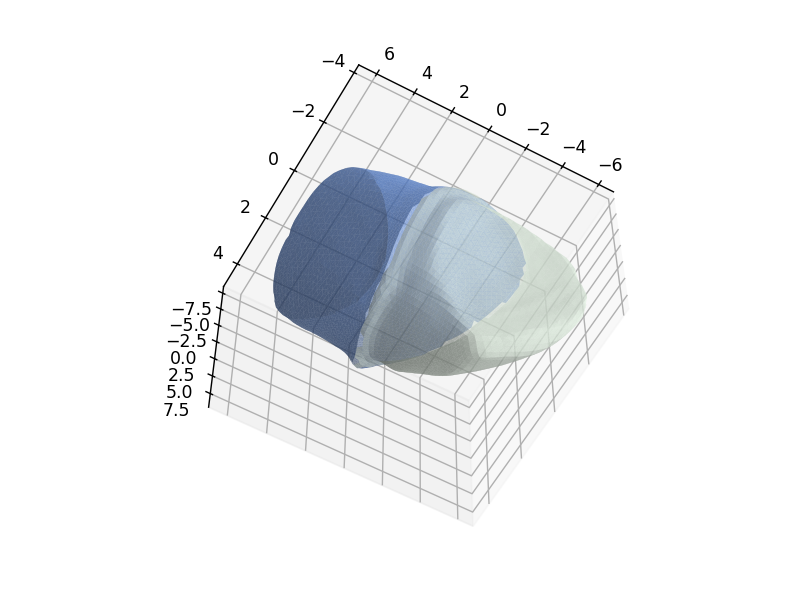

NameError: name 'interpolate_marks' is not defined

In [109]:
'''
输出最终图像
未完成
'''

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import splprep, splev
import networkx as nx


def generate_graph(vertices, faces):
    G = nx.Graph()
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)
    for face in faces:
        for i in range(len(face)):
            G.add_edge(face[i], face[(i+1) % len(face)])
    return G

def is_on_curve(vertex, curve_points, tolerance):
    for point in curve_points:
        if np.linalg.norm(vertex - point) < tolerance:
            return True
    return False

def segment_point_cloud(vertices, faces, interpolated_marks):
    tolerance = 0.1
    max_tolerance = 1.0
    tolerance_increment = 0.02

    while tolerance <= max_tolerance:
        G = generate_graph(vertices, faces)
        curve_points = np.array(interpolated_marks)
        
        # 找到封闭曲线上的顶点
        curve_points_indices = set()
        for i, vertex in enumerate(vertices):
            if is_on_curve(np.array(vertex), curve_points, tolerance):
                curve_points_indices.add(i)
        
        print(f"Trying with tolerance: {tolerance}")
        print(f"Number of inside points: {len(curve_points_indices)}")
        
        # 从图中删除封闭曲线上的点
        G.remove_nodes_from(curve_points_indices)
        
        # 使用图的连通性找到两个区域
        components = list(nx.connected_components(G))
        part1 = set()
        part2 = set()
        
        if len(components) > 1:
            part1 = components[0]
            part2 = components[1]
            return part1, part2, curve_points_indices
        else:
            tolerance += tolerance_increment
    
    print("Segmentation failed: Unable to find two separate components.")
    return set(), set(), set()

def plot_surface_with_predicted_points(vertices, faces, marks, part1, part2, inside_points, angles=(0, 0, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)

    x, y, z = vertices.T

    try:
        # 标记分割的点云部分
        part1_faces = [face for face in faces if set(face) & part1]
        part2_faces = [face for face in faces if set(face) & part2]
        
        part1_faces = np.array(part1_faces)
        part2_faces = np.array(part2_faces)
        
        if len(part1_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
        if len(part2_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

    except ValueError as e:
        print(f"ValueError: {e}")
        return

    # 插值标记点并绘制曲线
    interpolated_marks = interpolate_marks(marks)
    interpolated_marks = rotate_points(interpolated_marks, angles)
    ax.plot(interpolated_marks[:, 0], interpolated_marks[:, 1], interpolated_marks[:, 2], c='red', label='Predicted Contour Line')
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Predicted Contour Line and Segmentation')

    # 添加图例
    ax.legend()

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    ax.view_init(elev=30, azim=30)  # This will be overridden by rotation

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()


# 分割点云
part1, part2, inside_points = segment_point_cloud(centered_vertices, faces, smooth_center_line)

# 输出每个部分的点数
print(f"Number of vertices in part 1: {len(part1)}")
print(f"Number of vertices in part 2: {len(part2)}")

# 调整视角 (angles in radians)
plot_surface_with_predicted_points(centered_vertices, faces, smooth_center_line, part1, part2, inside_points, angles=(np.radians(90), np.radians(-30), np.radians(30)))
